In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
from statsmodels.formula.api import ols #more advanced than scikit-learn
from statsmodels.formula.api import ols as sm_ols

from statsmodels.tsa.stattools import adfuller #?
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score #haven't implemented the r2_score yet
from sklearn.linear_model import LinearRegression #haven't implemented yet
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split #haven't implemented yet
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from math import sqrt
import seaborn as sns
import pandas_datareader.data as reader
import math
import matplotlib.pyplot as plt

import pandas_datareader as pdr 

In [2]:
returns = pd.read_csv('returns.csv')
returns['date'] = pd.to_datetime(returns['date'], format='%Y%m%d', errors='coerce') #change dates format
returns['RET'] = returns['RET'].apply(pd.to_numeric, errors='coerce') #had to change the ret to numeric values 
returns = returns.drop(['PRC','PERMNO'],axis=1)
returns = returns.rename(columns={'date':'Date'})
returns

,Date,NCUSIP,TICKER,RET,ewretd,sprtrn
0,2000-01-03,13810830,CITI,-0.067797,0.002878,-0.009549
1,2000-01-04,13810830,CITI,-0.072727,-0.017465,-0.038345
2,2000-01-05,13810830,CITI,0.078431,0.007821,0.001922
3,2000-01-06,13810830,CITI,-0.018182,0.004504,0.000956
4,2000-01-07,13810830,CITI,-0.055556,0.017008,0.027090
...,...,...,...,...,...,...
15928,2020-12-24,02079K30,GOOGL,0.003431,-0.000277,0.003537
15929,2020-12-28,02079K30,GOOGL,0.022951,0.001350,0.008723
15930,2020-12-29,02079K30,GOOGL,-0.009132,-0.008483,-0.002227
15931,2020-12-30,02079K30,GOOGL,-0.012237,0.010155,0.001342


In [3]:
ff = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3_daily',start=2019,end=2021)[0] # the [0] is because the imported obect is a dictionary, and key=0 is the dataframe
ff = ff.reset_index().rename(columns={"Mkt-RF":"mkt_excess"}) 
ff[['mkt_excess', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] = ff[['mkt_excess', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] / 100 #convert to decimal format 
ff['year'] = ff['Date'].dt.year
ff['month'] = ff['Date'].dt.month

ff

,Date,mkt_excess,SMB,HML,RMW,CMA,RF,year,month
0,2019-01-02,0.0023,0.0072,0.0110,-0.0012,0.0026,0.0001,2019,1
1,2019-01-03,-0.0245,0.0052,0.0121,-0.0025,0.0091,0.0001,2019,1
2,2019-01-04,0.0355,0.0037,-0.0070,-0.0008,-0.0058,0.0001,2019,1
3,2019-01-07,0.0094,0.0084,-0.0077,-0.0069,-0.0041,0.0001,2019,1
4,2019-01-08,0.0101,0.0045,-0.0064,0.0036,-0.0009,0.0001,2019,1
...,...,...,...,...,...,...,...,...,...
500,2020-12-24,0.0021,-0.0043,-0.0017,0.0024,-0.0005,0.0000,2020,12
501,2020-12-28,0.0046,-0.0065,0.0032,0.0146,0.0050,0.0000,2020,12
502,2020-12-29,-0.0040,-0.0142,0.0024,0.0075,-0.0028,0.0000,2020,12
503,2020-12-30,0.0027,0.0103,0.0004,-0.0067,-0.0006,0.0000,2020,12


In [4]:
Returns = pd.merge(returns, ff, on='Date',how='inner')
Returns

#filter dataset to 4 stocks we are observing (COULDNT FIND CITI)

Returns = Returns[(Returns['TICKER'] == 'AAPL') | 
                  (Returns['TICKER'] == 'COKE') |
                  (Returns['TICKER'] == 'GOOGL')]

#get in logrithmic returns to account for continuous compounding (didn't apply it to risk free rate)
Returns[['RET','ewretd','sprtrn','mkt_excess','SMB','HML','RMW','CMA','RF']] = np.log(1 + Returns[['RET','ewretd','sprtrn','mkt_excess','SMB','HML','RMW','CMA','RF']])
Returns[['RET','ewretd','sprtrn','mkt_excess','SMB','HML','RMW','CMA','RF']] = 1 + Returns[['RET','ewretd','sprtrn','mkt_excess','SMB','HML','RMW','CMA','RF']]
Returns

,Date,NCUSIP,TICKER,RET,ewretd,sprtrn,mkt_excess,SMB,HML,RMW,CMA,RF,year,month
0,2019-01-02,19109810,COKE,1.015274,1.016940,1.001268,1.002297,1.007174,1.010940,0.998799,1.002597,1.0001,2019,1
1,2019-01-02,03783310,AAPL,1.001140,1.016940,1.001268,1.002297,1.007174,1.010940,0.998799,1.002597,1.0001,2019,1
2,2019-01-02,02079K30,GOOGL,1.009259,1.016940,1.001268,1.002297,1.007174,1.010940,0.998799,1.002597,1.0001,2019,1
3,2019-01-03,19109810,COKE,0.987597,0.990501,0.974931,0.975195,1.005187,1.012027,0.997497,1.009059,1.0001,2019,1
4,2019-01-03,03783310,AAPL,0.895076,0.990501,0.974931,0.975195,1.005187,1.012027,0.997497,1.009059,1.0001,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1510,2020-12-30,03783310,AAPL,0.991436,1.010104,1.001341,1.002696,1.010247,1.000400,0.993277,0.999400,1.0000,2020,12
1511,2020-12-30,02079K30,GOOGL,0.987688,1.010104,1.001341,1.002696,1.010247,1.000400,0.993277,0.999400,1.0000,2020,12
1512,2020-12-31,19109810,COKE,0.999137,0.998941,1.006418,1.003892,0.993076,1.004490,1.005584,0.997998,1.0000,2020,12
1513,2020-12-31,03783310,AAPL,0.992267,0.998941,1.006418,1.003892,0.993076,1.004490,1.005584,0.997998,1.0000,2020,12


In [22]:
Returns_monthly = (Returns.groupby('TICKER').resample('M', on='Date').prod() -1).reset_index()
Returns_monthly['year'], Returns_monthly['month'] = Returns_monthly['Date'].dt.year, Returns_monthly['Date'].dt.month
Returns_monthly['RET'] = Returns_monthly['RET'] - Returns_monthly['RF']
Returns_monthly

,TICKER,Date,RET,ewretd,sprtrn,mkt_excess,SMB,HML,RMW,CMA,RF,year,month
0,AAPL,2019-01-31,0.041913,0.117579,0.077087,0.082261,0.027544,-0.005358,-0.006032,-0.013561,0.002102,2019,1
1,AAPL,2019-02-28,0.041859,0.039353,0.029458,0.033586,0.017554,-0.025938,0.000578,-0.013834,0.001902,2019,2
2,AAPL,2019-03-31,0.092820,-0.001768,0.017359,0.010148,-0.034957,-0.042184,0.008026,-0.010651,0.001892,2019,3
3,AAPL,2019-04-30,0.053388,0.020927,0.039118,0.039217,-0.011300,0.019033,0.015758,-0.021238,0.002102,2019,4
4,AAPL,2019-05-31,-0.130714,-0.066384,-0.066650,-0.070270,-0.015539,-0.025296,-0.006401,0.018494,0.001982,2019,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,GOOGL,2020-08-31,0.093503,0.040180,0.069674,0.076088,-0.009448,-0.029964,0.040520,-0.013719,0.000000,2020,8
68,GOOGL,2020-09-30,-0.105532,-0.025043,-0.041636,-0.038699,0.000152,-0.030188,-0.012516,-0.018802,0.000000,2020,9
69,GOOGL,2020-10-31,0.096226,0.003063,-0.029482,-0.022722,0.046907,0.039253,-0.005573,-0.005520,0.000000,2020,10
70,GOOGL,2020-11-30,0.082548,0.170860,0.106194,0.124006,0.058971,0.013968,-0.023112,0.007975,0.000000,2020,11


In [179]:
def reg_in_groupby(df,formula="RET ~ mkt_excess + SMB + HML + RMW + CMA"):
    return pd.Series(sm.formula.ols(formula,data = df).fit().params)

# def r2(df,formula="RET ~ mkt_excess + SMB + HML + RMW + CMA"):
#     return pd.Series(sm.formula.ols(formula,data = df).fit().rsquared)

# def pred(df,formula="RET ~ mkt_excess + SMB + HML + RMW + CMA"):
#     return pd.Series(sm.formula.ols(formula,data = df).fit().predict())


In [180]:
# r_2 = (
#     Returns
#     .groupby(['year','month','TICKER']).apply(r2)
#     .rename(columns={0:'r2'})
#     .reset_index())
# r_2

betas = (
    Returns
    .groupby(['year','month','TICKER']).apply(reg_in_groupby)
    .rename(columns={'mkt_excess':'mkt_beta','SMB':'SMB_beta','HML':'HML_beta','RMW':'RMW_beta','CMA':'CMA_beta'})
    .reset_index())
betas

,year,month,TICKER,Intercept,mkt_beta,SMB_beta,HML_beta,RMW_beta,CMA_beta
0,2019,1,AAPL,2.572955,0.958470,-0.378956,-0.319576,2.869870,-4.705670
1,2019,1,COKE,-5.415930,0.636594,1.985256,-2.183031,3.084874,2.898831
2,2019,1,GOOGL,1.743271,1.623905,-1.102854,0.087046,-2.013528,0.660786
3,2019,2,AAPL,1.954642,0.792085,0.064702,-0.274835,0.018623,-1.555874
4,2019,2,COKE,-3.270891,-1.190630,3.746582,-2.140673,-1.628876,5.491552
...,...,...,...,...,...,...,...,...,...
67,2020,11,COKE,-2.129516,1.165183,0.405588,-0.200633,-0.284737,2.041729
68,2020,11,GOOGL,1.293378,1.345731,-0.450508,0.230917,-0.276411,-1.145685
69,2020,12,AAPL,-2.377692,1.186498,-0.338630,-1.975176,0.372975,4.134430
70,2020,12,COKE,0.218357,0.108705,1.567428,0.257125,1.687689,-2.840233


In [183]:
dataset = pd.merge(betas, Returns_monthly,on=['year','month','TICKER'])

dataset['exp_ret_excess'] = (dataset['RF']
                            + (dataset['mkt_beta']*dataset['mkt_excess'])
                            + (dataset['SMB_beta']*dataset['SMB'])
                            + (dataset['HML_beta']*dataset['HML'])
                            + (dataset['RMW_beta']*dataset['RMW'])
                            + (dataset['CMA_beta']*dataset['CMA']))

dataset

,year,month,TICKER,Intercept,mkt_beta,SMB_beta,HML_beta,RMW_beta,CMA_beta,Date,RET,ewretd,sprtrn,mkt_excess,SMB,HML,RMW,CMA,RF,exp_ret_excess
0,2019,1,AAPL,2.572955,0.958470,-0.378956,-0.319576,2.869870,-4.705670,2019-01-31,0.041913,0.117579,0.077087,0.082261,0.027544,-0.005358,-0.006032,-0.013561,0.002102,0.118725
1,2019,1,COKE,-5.415930,0.636594,1.985256,-2.183031,3.084874,2.898831,2019-01-31,0.210321,0.117579,0.077087,0.082261,0.027544,-0.005358,-0.006032,-0.013561,0.002102,0.062926
2,2019,1,GOOGL,1.743271,1.623905,-1.102854,0.087046,-2.013528,0.660786,2019-01-31,0.071222,0.117579,0.077087,0.082261,0.027544,-0.005358,-0.006032,-0.013561,0.002102,0.108028
3,2019,2,AAPL,1.954642,0.792085,0.064702,-0.274835,0.018623,-1.555874,2019-02-28,0.041859,0.039353,0.029458,0.033586,0.017554,-0.025938,0.000578,-0.013834,0.001902,0.058304
4,2019,2,COKE,-3.270891,-1.190630,3.746582,-2.140673,-1.628876,5.491552,2019-02-28,0.138079,0.039353,0.029458,0.033586,0.017554,-0.025938,0.000578,-0.013834,0.001902,0.006292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2020,11,COKE,-2.129516,1.165183,0.405588,-0.200633,-0.284737,2.041729,2020-11-30,0.137457,0.170860,0.106194,0.124006,0.058971,0.013968,-0.023112,0.007975,0.000000,0.188469
68,2020,11,GOOGL,1.293378,1.345731,-0.450508,0.230917,-0.276411,-1.145685,2020-11-30,0.082548,0.170860,0.106194,0.124006,0.058971,0.013968,-0.023112,0.007975,0.000000,0.140789
69,2020,12,AAPL,-2.377692,1.186498,-0.338630,-1.975176,0.372975,4.134430,2020-12-31,0.110699,0.076433,0.036776,0.045351,0.044864,-0.014858,-0.021044,-0.000800,0.000000,0.056807
70,2020,12,COKE,0.218357,0.108705,1.567428,0.257125,1.687689,-2.840233,2020-12-31,0.016058,0.076433,0.036776,0.045351,0.044864,-0.014858,-0.021044,-0.000800,0.000000,0.038187


In [188]:
sub = dataset.copy()
sub = sub[['Date','year','month','TICKER','RET','exp_ret_excess']]
sub['resid'] = sub['RET'] - sub['exp_ret_excess'] #over_est = neg, under_est=pos
sub

,Date,year,month,TICKER,RET,exp_ret_excess,resid
0,2019-01-31,2019,1,AAPL,0.041913,0.118725,-0.076812
1,2019-01-31,2019,1,COKE,0.210321,0.062926,0.147395
2,2019-01-31,2019,1,GOOGL,0.071222,0.108028,-0.036807
3,2019-02-28,2019,2,AAPL,0.041859,0.058304,-0.016444
4,2019-02-28,2019,2,COKE,0.138079,0.006292,0.131787
...,...,...,...,...,...,...,...
67,2020-11-30,2020,11,COKE,0.137457,0.188469,-0.051012
68,2020-11-30,2020,11,GOOGL,0.082548,0.140789,-0.058241
69,2020-12-31,2020,12,AAPL,0.110699,0.056807,0.053892
70,2020-12-31,2020,12,COKE,0.016058,0.038187,-0.022129


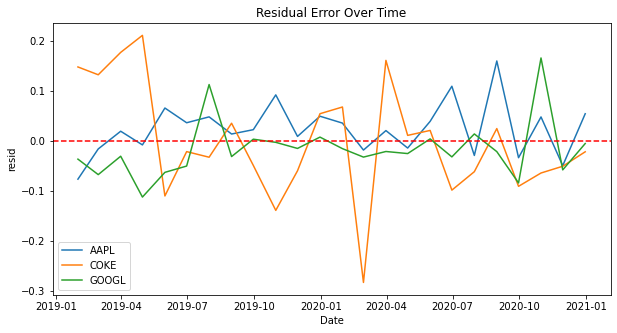

In [224]:
fig = plt.figure(figsize=(10, 5))
sns.lineplot(x='Date',y='resid',data=sub,hue='TICKER')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Error Over Time')

plt.legend()
plt.show()



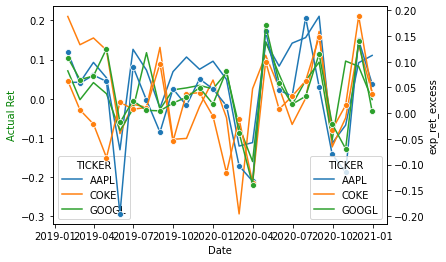

<Figure size 720x360 with 0 Axes>

In [240]:
fig, ax1 = plt.subplots() # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 
fig = plt.figure(figsize=(10, 5))
sns.lineplot(x = 'Date', y = 'RET',data=sub,hue='TICKER', ax = ax1, color = 'blue') # plots the first set of data, and sets it to ax1. 
sns.lineplot(x = 'Date', y = 'exp_ret_excess',data=sub,hue='TICKER', marker = 'o', color = 'red', ax = ax2) # plots the second set, and sets to ax2. 

# these lines add the annotations for the plot. 
ax1.set_xlabel('Date')
ax1.set_ylabel('Actual Ret', color='g')
ax2.set_ylabel('Exp Ret', color='b')

plt.show(); # shows the plot. 

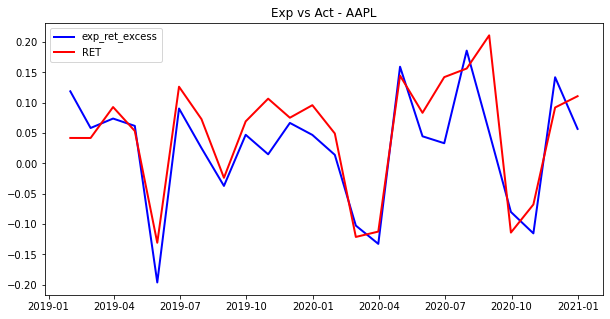

In [255]:
fig = plt.figure(figsize=(10, 5))

plt.plot( 'Date', 'exp_ret_excess', data=sub[sub['TICKER']=='AAPL'], color='blue', linewidth=2)
plt.plot( 'Date', 'RET', data=sub[sub['TICKER']=='AAPL'], color='red', linewidth=2)

plt.title('Exp vs Act - AAPL')
plt.legend()
plt.show()
 

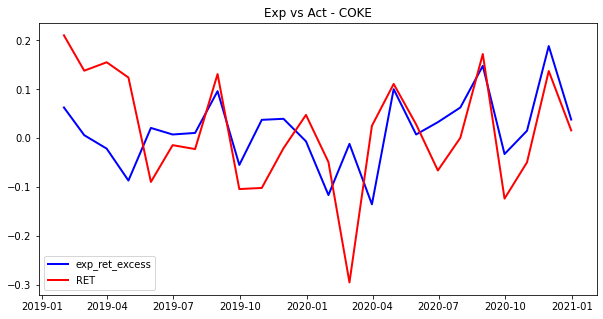

In [256]:
fig = plt.figure(figsize=(10, 5))

plt.plot( 'Date', 'exp_ret_excess', data=sub[sub['TICKER']=='COKE'], color='blue', linewidth=2)
plt.plot( 'Date', 'RET', data=sub[sub['TICKER']=='COKE'], color='red', linewidth=2)

plt.title('Exp vs Act - COKE')
plt.legend()
plt.show()

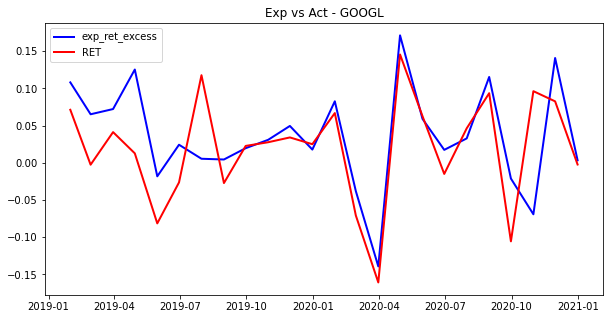

In [257]:
fig = plt.figure(figsize=(10, 5))

plt.plot( 'Date', 'exp_ret_excess', data=sub[sub['TICKER']=='GOOGL'], color='blue', linewidth=2)
plt.plot( 'Date', 'RET', data=sub[sub['TICKER']=='GOOGL'], color='red', linewidth=2)

plt.title('Exp vs Act - GOOGL')
plt.legend()
plt.show()